## Predicting House Sale Prices

For this project, we'll see how to develop the __linear regression model__ for predicting house sale prices at the same time we understand different approaches to model fitting, and some techniques for cleaning, transforming, and selecting features.

We'll work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. Some information about the dataset can be founded [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) and the different columns of the set are explained [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

We'll start by setting up a pipeline of functions that will let us quickly iterate on different models.

### Setting up the environment

In [70]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read dataset
data = pd.read_csv('AmesHousing.tsv', sep='\t')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [3]:
# Function to return a dataframe with the desired features
def transform_features(dataset):
    return dataset

In [4]:
# Function to return desired columns from dataframe
def select_features(dataset):
    return dataset[["Gr Liv Area", "SalePrice"]]

In [68]:
# Function to evaluate the linear regression model
def train_and_test(dataset):
    threshold = 1460
    train = dataset[:threshold]
    test = dataset[threshold:]
    numerical_cols = dataset.select_dtypes(include=['uint8', 'int', 'float'])
    numerical_cols.drop(columns='SalePrice', inplace=True)
    cols = numerical_cols.columns
    
    lr = LinearRegression()
    lr.fit(train[cols], train['SalePrice'])
    
    test_predictions = lr.predict(test[cols])
    test_rmse = np.sqrt(mean_squared_error(test['SalePrice'], test_predictions))
    
    return test_rmse

### Feature engineering

As a first step to develop the model, let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. For this, we'll make use of the previously defined `transform_features` function, updating it so that any column from the data frame with more than 25% (or another cutoff value) missing values is dropped. We'll also need to remove any columns that leak information about the sale. In general, the goal of this function is to:

- Remove features that we don't want to use in the model, just based on the number of missing values or data leakage.
- Transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc).
- Create new features by combining other features.

Succeeding in predictive modeling is highly dependent on the quality of features the model has. Libraries like `scikit-learn` have made it quick and easy to simply try and tweak many different models, but cleaning, selecting, and transforming features are still more of an art that requires a bit of human ingenuity. To accomplish this, we'll need to get more familiar with the  columns of the dataset determining what transformations are necessary (if any).

#### 1. Handle missing values

Now, we'll focus on handling columns with missing values. When values are missing in a column, there are two main approaches we can take:

- Remove rows containing missing values for specific columns
    - Pro: Rows containing missing values are removed, leaving only clean data for modeling
    - Con: Entire observations from the training set are removed, which can reduce overall prediction accuracy
- Impute (or replace) missing values using a descriptive statistic from the column
    - Pro: Missing values are replaced with potentially similar estimates, preserving the rest of the observation in the model.
    - Con: Depending on the approach, we may be adding noisy data for the model to learn

The approach we'll use is:

- All columns:
    Drop any with 5% or more missing values for now.
- Text columns:
    Drop any with 1 or more missing values for now.
- Numerical columns:
    For columns with missing values, fill in with the most common value in that column

In [6]:
# All columns
threshold = len(data) * 0.05
data_null_counts = data.isnull().sum()
data_more_five_nan = data_null_counts[data_null_counts > threshold]
print('Total columns to remove: {}\nMissing Values per column:\n{}'.format(len(data_more_five_nan), data_more_five_nan.sort_values(ascending=False)))
data.drop(data_more_five_nan.index, axis=1, inplace=True)

Total columns to remove: 11
Missing Values per column:
Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Fireplace Qu     1422
Lot Frontage      490
Garage Cond       159
Garage Qual       159
Garage Finish     159
Garage Yr Blt     159
Garage Type       157
dtype: int64


In [7]:
# Text columns
text_cols = data.select_dtypes(include=['object']).isnull().sum()
text_cols_with_nan = text_cols[text_cols != 0]
print('Total columns to remove: {}\nMissing Values per column:\n{}'.format(len(text_cols_with_nan), text_cols_with_nan.sort_values(ascending=False)))
data.drop(text_cols_with_nan.index, axis=1, inplace=True)

Total columns to remove: 7
Missing Values per column:
Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Cond         80
Bsmt Qual         80
Mas Vnr Type      23
Electrical         1
dtype: int64


In [8]:
# Numerical columns (1)
numerical_cols = data.select_dtypes(include=['int', 'float']).isnull().sum()
numerical_cols_with_nan = numerical_cols[numerical_cols != 0]
print('Total columns to impute: {}\nMissing Values per column:\n{}'.format(len(numerical_cols_with_nan), numerical_cols_with_nan.sort_values(ascending=False)))

Total columns to impute: 9
Missing Values per column:
Mas Vnr Area      23
Bsmt Half Bath     2
Bsmt Full Bath     2
Garage Area        1
Garage Cars        1
Total Bsmt SF      1
Bsmt Unf SF        1
BsmtFin SF 2       1
BsmtFin SF 1       1
dtype: int64


In [9]:
# Numerical columns (2)
modes_dict = data[numerical_cols_with_nan.index].mode().to_dict('records')[0]
print(modes_dict)
data.fillna(modes_dict, inplace=True)

{'Garage Cars': 2.0, 'Bsmt Half Bath': 0.0, 'Total Bsmt SF': 0.0, 'Garage Area': 0.0, 'Bsmt Full Bath': 0.0, 'Mas Vnr Area': 0.0, 'Bsmt Unf SF': 0.0, 'BsmtFin SF 2': 0.0, 'BsmtFin SF 1': 0.0}


In [10]:
# Check results of removal of the missing values
print(data.isnull().sum().value_counts())

0    64
dtype: int64


#### 2. New features creation

What new features can we create, that better capture the information in some of the features? To answer this question, a good domain knowledge can help us to understand how to best transform features to represent information well for a linear model. If we're ever confused about a feature or how it should be represented, reading scientific papers or posts by researchers in the specific domain is critical.

In [11]:
# Some practical information
years_sold = data['Yr Sold'] - data['Year Built']
print('Wrong values for years_sold:', years_sold[years_sold < 0], sep='\n')
years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
print('Wrong values for years_since_remod:', years_since_remod[years_since_remod < 0], sep='\n')

# Create new columns
data['Years Before Sale'] = years_sold
data['Years Since Remod'] = years_since_remod

Wrong values for years_sold:
2180   -1
dtype: int64
Wrong values for years_since_remod:
1702   -1
2180   -2
2181   -1
dtype: int64


In [12]:
# Drop rows with negative values for both of these new features
data = data.drop([1702, 2180, 2181], axis=0)

# No longer need original year columns
data = data.drop(["Year Built", "Year Remod/Add"], axis = 1)

#### 3. Drop non useful columns

Finally, we can drop columns which aren't useful for machine learning or other columns that leak data about the final sale.

In [13]:
# Drop columns that aren't useful for ML
data = data.drop(["PID", "Order"], axis=1)

# Drop columns that leak info about the final sale
data = data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

With all of this, we can update the `transform_features` function to obtain the final dataset.

In [14]:
# Function to return a dataframe with the desired features
def transform_features(data):
    # All columns
    threshold = len(data) * 0.05
    data_null_counts = data.isnull().sum()
    data_more_five_nan = data_null_counts[data_null_counts > threshold]
    data.drop(data_more_five_nan.index, axis=1, inplace=True)
    # Text columns
    text_cols = data.select_dtypes(include=['object']).isnull().sum()
    text_cols_with_nan = text_cols[text_cols != 0]
    data.drop(text_cols_with_nan.index, axis=1, inplace=True)
    # Numerical columns
    numerical_cols = data.select_dtypes(include=['int', 'float']).isnull().sum()
    numerical_cols_with_nan = numerical_cols[numerical_cols != 0]
    modes_dict = data[numerical_cols_with_nan.index].mode().to_dict('records')[0]
    data.fillna(modes_dict, inplace=True)
    
    # Some practical information
    years_sold = data['Yr Sold'] - data['Year Built']
    years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    # Create new columns
    data['Years Before Sale'] = years_sold
    data['Years Since Remod'] = years_since_remod
    # Drop rows with negative values for both of these new features
    data = data.drop([1702, 2180, 2181], axis=0)
    # No longer need original year columns
    data = data.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    # Drop columns that aren't useful for ML
    data = data.drop(["PID", "Order"], axis=1)
    # Drop columns that leak info about the final sale
    data = data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)
    
    return data

In [15]:
# Check results
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
print(rmse)

55275.36731241307


### Feature selection

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features. In the machine learning workflow, once we've selected the model we want to use, selecting the appropriate features for that model is the next important step. 

We'll explore how to use correlation between features and the target column, correlation between features, and variance of features to select features.

#### 1. Correlation between features and the target column

Firstly, let's focus on just how the feature columns correlate with the target column.

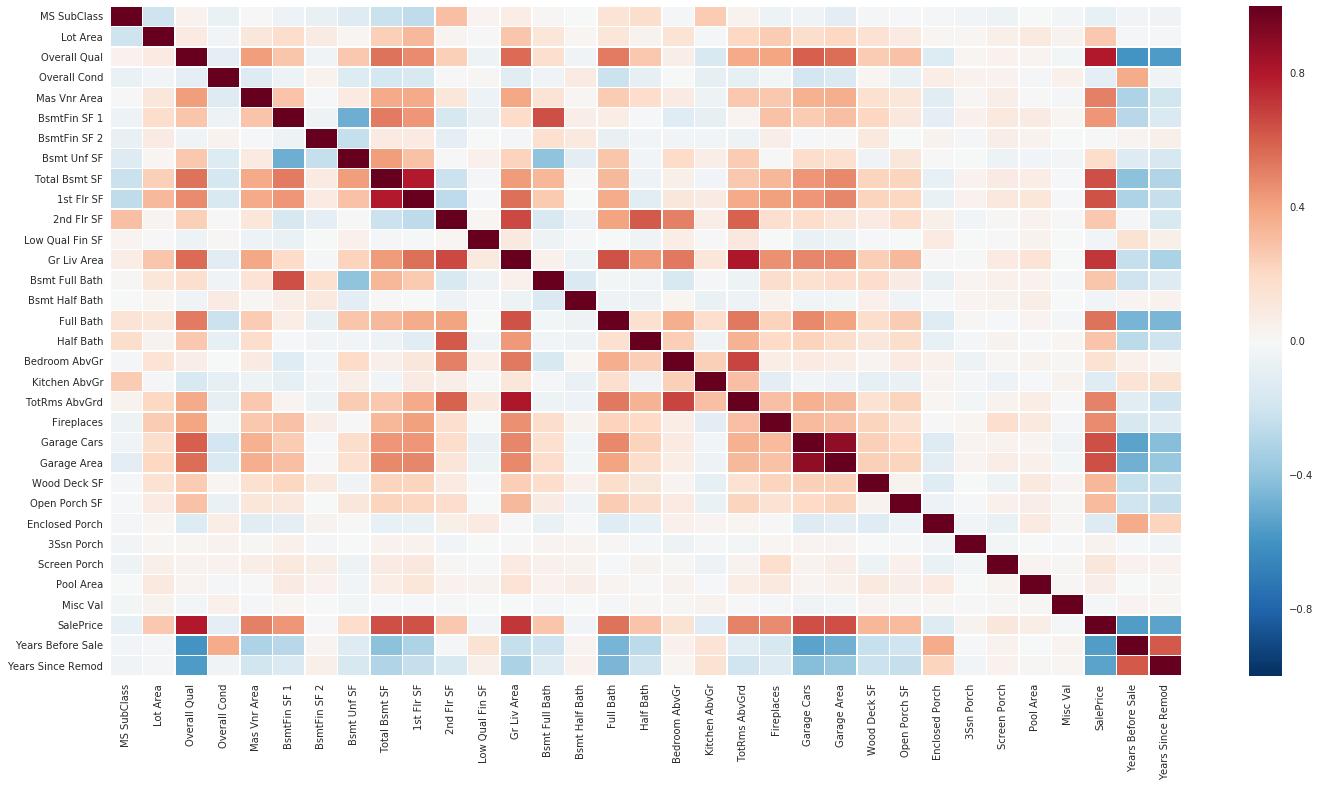

In [16]:
# Generate a correlation heatmap of the numerical features
numerical_data = data.select_dtypes(include=['int', 'float'])
corrs = numerical_data.corr()
f, ax = plt.subplots(figsize=(24, 12))
sns.heatmap(corrs, linewidths=.5, ax=ax)
plt.show()

In [17]:
# Correlations with our target value
abs_corr_coeffs = numerical_data.corr()['SalePrice'].abs().sort_values(ascending=False)
print('Correlations with our target value:', abs_corr_coeffs, sep='\n')

Correlations with our target value:
SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
Bsmt

We now have a decent list of candidate features to use in our model, sorted by how strongly they're correlated with the `SalePrice` column. For now, let's keep only the features that have a correlation of 0.4 or higher. This cutoff is a bit arbitrary and, in general, it's a good idea to experiment with this cutoff. For example, we can train and test models using different cutoffs and see where your model stops improving.

In [18]:
# Strong correlation features
strong_corr_coeffs = abs_corr_coeffs[abs_corr_coeffs > 0.4].copy()
print('Selected features correlation:', strong_corr_coeffs, sep='\n')
weak_corr_coeffs = abs_corr_coeffs[abs_corr_coeffs < 0.4].copy()
print('Removed features correlation:', weak_corr_coeffs, sep='\n')

# Drop weak correlation features
data.drop(weak_corr_coeffs.index, axis=1, inplace=True)

Selected features correlation:
SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Name: SalePrice, dtype: float64
Removed features correlation:
Wood Deck SF       0.328183
Open Porch SF      0.316262
Half Bath          0.284871
Bsmt Full Bath     0.276258
2nd Flr SF         0.269601
Lot Area           0.267520
Bsmt Unf SF        0.182751
Bedroom AbvGr      0.143916
Enclosed Porch     0.128685
Kitchen AbvGr      0.119760
Screen Porch       0.112280
Overall Cond       0.101540
MS SubClass        0.085128
Pool Area          0.068438
Low Qual Fin SF    0.037629
Bsmt Half Bath     0.035875
3Ssn Porch         0.032268
Misc Val   

#### 2. Collinearity between the feature columns

Collinearity is when 2 feature columns are highly correlated and stand the risk of duplicating information. If we have 2 features that convey the same information using 2 different measures or metrics, we don't need to keep both.

While we can check for collinearity between 2 columns using the correlation matrix, we run the risk of information overload. We can instead generate a correlation matrix heatmap using Seaborn to visually compare the correlations and look for problematic pairwise feature correlations. Because we're looking for outlier values in the heatmap, this visual representation is easier.

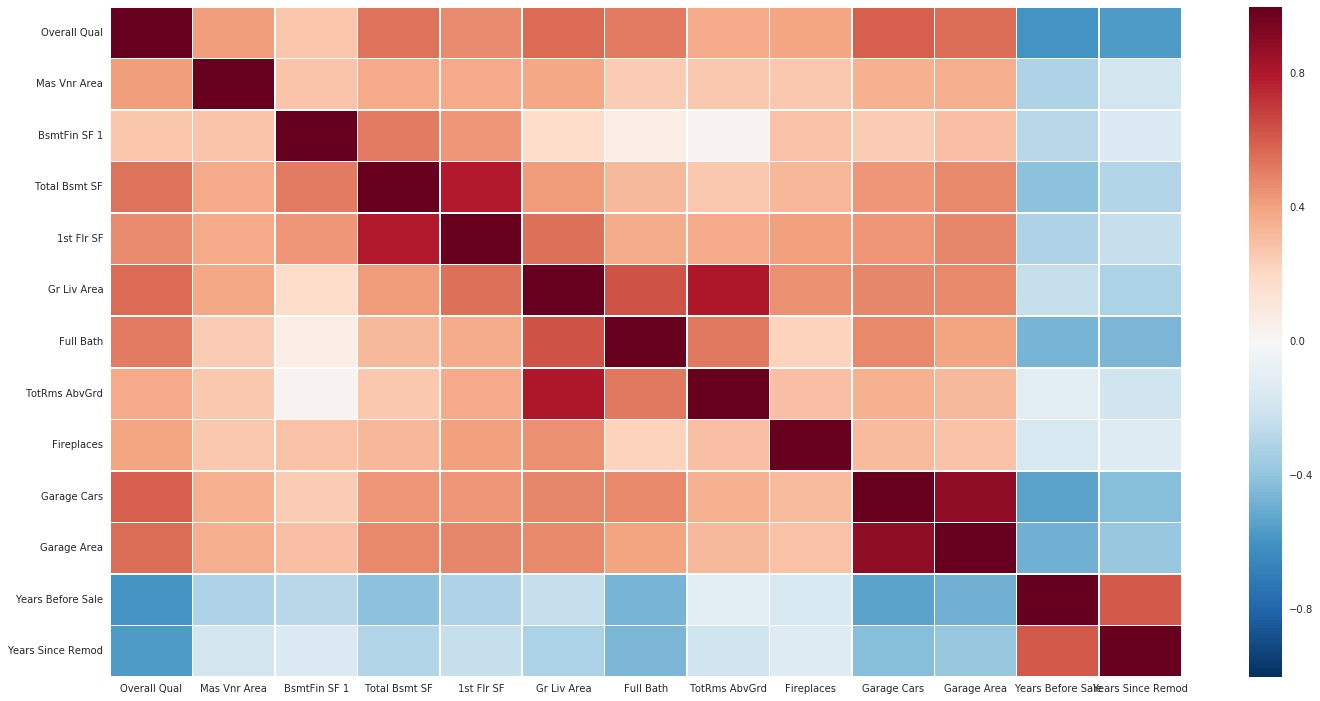

In [23]:
# Generate a new correlation heatmap of the numerical features
numerical_data = data.select_dtypes(include=['int', 'float']).copy()
numerical_data.drop('SalePrice', axis=1, inplace=True)
corrs = numerical_data.corr()
f, ax = plt.subplots(figsize=(24, 12))
sns.heatmap(corrs, linewidths=.5, ax=ax)
plt.show()

Based on the correlation matrix heatmap, we can tell that the following pairs of columns are strongly correlated:

- `Gr Liv Area` and `TotRms AbvGrd`
- `Garage Area` and `Garage Cars`
- `1st Flr SF` and `Total Bsmt SF`

If we read the descriptions of these columns from the data documentation, we can tell that for the first two pair of columns the information reflected is very similar. Because `Gr Liv Area` and `Garage Area` are continuous variables that capture more nuance, let's drop the `TotRms AbvGrd` and `Garage Cars`.

As per the third pair of columns, we can infer that 1st floor square feet and basement square feet are very related in common houses, so we can keep only one of them.


In [24]:
# Drop correlated columns
data.drop(['Garage Cars', 'TotRms AbvGrd', 'Total Bsmt SF'], axis=1, inplace=True)

#### 3. Variance of features

The last technique we'll explore is removing features with low variance. When the values in a feature column have low variance, they don't meaningfully contribute to the model's predictive capability. On the extreme end, let's imagine a column with a variance of 0. This would mean that all of the values in that column were exactly the same. This means that the column isn't informative and isn't going to help the model make better predictions.

To make apples to apples comparisons between columns, we need to rescale all of the columns to vary between 0 and 1. This is known as min-max scaling or as rescaling.

In [29]:
# Rescaling of features
numerical_data = data.select_dtypes(include=['int', 'float']).copy()
numerical_data.drop('SalePrice', axis=1, inplace=True)
numerical_data_rescaling = (numerical_data - numerical_data.min()) / (numerical_data.max() - numerical_data.min())
print('Check min values:', numerical_data_rescaling.min(), sep='\n')
print('Check max values:', numerical_data_rescaling.max(), sep='\n')

Check min values:
Overall Qual         0.0
Mas Vnr Area         0.0
BsmtFin SF 1         0.0
1st Flr SF           0.0
Gr Liv Area          0.0
Full Bath            0.0
Fireplaces           0.0
Garage Area          0.0
Years Before Sale    0.0
Years Since Remod    0.0
dtype: float64
Check max values:
Overall Qual         1.0
Mas Vnr Area         1.0
BsmtFin SF 1         1.0
1st Flr SF           1.0
Gr Liv Area          1.0
Full Bath            1.0
Fireplaces           1.0
Garage Area          1.0
Years Before Sale    1.0
Years Since Remod    1.0
dtype: float64


Let's compute the variances and remove the columns with the lowest variance.

In [30]:
# Compute variance of features
print(numerical_data_rescaling.var().sort_values(ascending=False))

Years Since Remod    0.120806
Years Before Sale    0.049585
Fireplaces           0.026216
Overall Qual         0.024461
Garage Area          0.020827
Full Bath            0.019077
Mas Vnr Area         0.012250
Gr Liv Area          0.008794
1st Flr SF           0.007742
BsmtFin SF 1         0.006348
dtype: float64


We see that the last four columns with the lowest variance are far from the next ones, so we can safely remove these features and train and test a model using the remaining features.

In [31]:
# Drop low variance columns
data.drop(['Mas Vnr Area', 'Gr Liv Area', '1st Flr SF', 'BsmtFin SF 1'], axis=1, inplace=True)

### Processing and transforming features

We'll explore how to transform some of the remaining features so we can use them in our model. First, we'll analyze which columns in the data frame should be converted to the categorical data type. All of the columns that can be categorized as nominal variables are candidates for being converted to categorical. Here are some other things we should think about:

- If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.
- Which categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category? This would be similar to a low variance numerical feature (no variability in the data for the model to capture).
- Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?

In [33]:
# List of nominal features 
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

# Check which categorical columns we still have
data_cat_cols = []
for col in nominal_features:
    if col in data.columns:
        data_cat_cols.append(col)

print('Categorical features included:', data_cat_cols, sep='\n')

Categorical features included:
['MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Heating', 'Central Air']


In [39]:
# Check how many unique values in each categorical column
uniqueness_counts = data[data_cat_cols].apply(lambda col: len(col.value_counts())).sort_values(ascending=False)
print('Uniqueness counts of categorical values:', uniqueness_counts, sep='\n')

# Aribtrary cutoff of 10 unique values
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10]
print('Removed features uniqueness counts:', drop_nonuniq_cols, sep='\n')

Uniqueness counts of categorical values:
Neighborhood    28
Exterior 2nd    17
Exterior 1st    16
Condition 1      9
Roof Matl        8
House Style      8
Condition 2      8
MS Zoning        7
Heating          6
Foundation       6
Roof Style       6
Bldg Type        5
Lot Config       5
Land Contour     4
Central Air      2
Street           2
dtype: int64
Removed features uniqueness counts:
Neighborhood    28
Exterior 2nd    17
Exterior 1st    16
dtype: int64


In [40]:
data.drop(drop_nonuniq_cols.index, axis=1, inplace=True)

In [59]:
# Check percentage of unique values for the columns
data_cat_cols = []
for col in nominal_features:
    if col in data.columns:
        data_cat_cols.append(col)
        
for col in data_cat_cols:
    value_counts = data[col].value_counts().sort_values(ascending=False)
    print('Column:', col)
    print('Majority value:', value_counts[0])
    print('Sum of the rest of the values:', value_counts[1:].sum())
    print('Dominance percentage:', value_counts[0]/(value_counts[0]+value_counts[1:].sum()))
    print('Removal:', 'yes' if (value_counts[0]/(value_counts[0]+value_counts[1:].sum())) > 0.95 else 'no')
    print('')

Column: MS Zoning
Majority value: 2270
Sum of the rest of the values: 657
Dominance percentage: 0.775538093611206
Removal: no

Column: Street
Majority value: 2915
Sum of the rest of the values: 12
Dominance percentage: 0.9959002391527161
Removal: yes

Column: Land Contour
Majority value: 2632
Sum of the rest of the values: 295
Dominance percentage: 0.8992142125042706
Removal: no

Column: Lot Config
Majority value: 2138
Sum of the rest of the values: 789
Dominance percentage: 0.730440724291083
Removal: no

Column: Condition 1
Majority value: 2520
Sum of the rest of the values: 407
Dominance percentage: 0.8609497779296208
Removal: no

Column: Condition 2
Majority value: 2898
Sum of the rest of the values: 29
Dominance percentage: 0.9900922446190639
Removal: yes

Column: Bldg Type
Majority value: 2422
Sum of the rest of the values: 505
Dominance percentage: 0.8274683976768021
Removal: no

Column: House Style
Majority value: 1480
Sum of the rest of the values: 1447
Dominance percentage: 0.

In [60]:
data.drop(['Street', 'Condition 2', 'Roof Matl', 'Heating'], axis=1, inplace=True)

In [61]:
# Select just the remaining text columns and convert to categorical
text_cols = data.select_dtypes(include=['object'])
for col in text_cols:
    data[col] = data[col].astype('category')
    
# Create dummy columns and add back to the dataframe
data = pd.concat([data, pd.get_dummies(data.select_dtypes(include=['category']))], axis=1).drop(text_cols, axis=1)

In [67]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 99 columns):
Overall Qual          2927 non-null int64
Full Bath             2927 non-null int64
Fireplaces            2927 non-null int64
Garage Area           2927 non-null float64
SalePrice             2927 non-null int64
Years Before Sale     2927 non-null int64
Years Since Remod     2927 non-null int64
MS Zoning_A (agr)     2927 non-null uint8
MS Zoning_C (all)     2927 non-null uint8
MS Zoning_FV          2927 non-null uint8
MS Zoning_I (all)     2927 non-null uint8
MS Zoning_RH          2927 non-null uint8
MS Zoning_RL          2927 non-null uint8
MS Zoning_RM          2927 non-null uint8
Lot Shape_IR1         2927 non-null uint8
Lot Shape_IR2         2927 non-null uint8
Lot Shape_IR3         2927 non-null uint8
Lot Shape_Reg         2927 non-null uint8
Land Contour_Bnk      2927 non-null uint8
Land Contour_HLS      2927 non-null uint8
Land Contour_Low      2927 non-null uint8
Land Cont

With all of this, the process is completed. We can now update the function `select_features`.

In [65]:
# Function to return desired columns from dataframe
def select_features(data):
    numerical_data = data.select_dtypes(include=['int', 'float']).copy()
    # Correlations with our target value
    abs_corr_coeffs = numerical_data.corr()['SalePrice'].abs().sort_values(ascending=False).copy()
    weak_corr_coeffs = abs_corr_coeffs[abs_corr_coeffs < 0.4].copy()
    # Drop weak correlation features
    data.drop(weak_corr_coeffs.index, axis=1, inplace=True)
    # Drop correlated columns
    data.drop(['Garage Cars', 'TotRms AbvGrd', 'Total Bsmt SF'], axis=1, inplace=True)
    # Drop low variance columns
    data.drop(['Mas Vnr Area', 'Gr Liv Area', '1st Flr SF', 'BsmtFin SF 1'], axis=1, inplace=True)
    
    # List of nominal features 
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    # Check which categorical columns we still have
    data_cat_cols = []
    for col in nominal_features:
        if col in data.columns:
            data_cat_cols.append(col)
    # Check how many unique values in each categorical column
    uniqueness_counts = data[data_cat_cols].apply(lambda col: len(col.value_counts())).sort_values(ascending=False).copy()
    # Aribtrary cutoff of 10 unique values
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].copy()
    # Drop many unique values
    data.drop(drop_nonuniq_cols.index, axis=1, inplace=True)
    # Drop low variance unique values
    data.drop(['Street', 'Condition 2', 'Roof Matl', 'Heating'], axis=1, inplace=True)
    
    # Select just the remaining text columns and convert to categorical
    text_cols = data.select_dtypes(include=['object'])
    for col in text_cols:
        data[col] = data[col].astype('category')
    
    # Create dummy columns and add back to the dataframe
    data = pd.concat([data, pd.get_dummies(data.select_dtypes(include=['category']))], axis=1).drop(text_cols, axis=1)

    return data

In [69]:
# Check results
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
print(rmse)

38116.017457655806


### Train and test the model

Now for the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add a parameter named `k` that controls the type of cross validation that occurs.

In [73]:
# Function to evaluate the linear regression model
def train_and_test(data, k=0):
    numerical_cols = data.select_dtypes(include=['uint8', 'int', 'float'])
    numerical_cols.drop(columns='SalePrice', inplace=True)
    cols = numerical_cols.columns
    target = 'SalePrice'
    lr = LinearRegression()
    
    if k == 0:
        ### Holdout validation
        
        threshold = 1460
        train = data[:threshold]
        test = data[threshold:]

        lr.fit(train[cols], train[target])
        test_predictions = lr.predict(test[cols])
        test_rmse = np.sqrt(mean_squared_error(test[target], test_predictions))
        return test_rmse
    
    elif k == 1:
        ### Simple cross validation
        
        threshold = 1460
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_data = data.sample(frac=1, )
        fold_one = shuffled_data[:threshold]
        fold_two = shuffled_data[threshold:]
        
        lr.fit(fold_one[cols], fold_one[target])
        predictions_one = lr.predict(fold_two[cols])        
        mse_one = mean_squared_error(fold_two[target], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(fold_two[cols], fold_two[target])
        predictions_two = lr.predict(fold_one[cols])        
        mse_two = mean_squared_error(fold_one[target], predictions_two)
        rmse_two = np.sqrt(mse_two)
        avg_rmse = np.mean([rmse_one, rmse_two])
        return avg_rmse
    
    else:
        ### K-fold cross validation
        
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            lr.fit(train[cols], train[target])
            predictions = lr.predict(test[cols])
            mse = mean_squared_error(test[target], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        avg_rmse = np.mean(rmse_values)
        return rmse_values, avg_rmse

In [77]:
# Check final results
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=0)
print('Holdout validation rmse result:', rmse, sep='\n')

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=1)
print('Simple cross validation rmse result:', rmse, sep='\n')

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse_values, rmse = train_and_test(filtered_df, k=10)
print('K-fold cross validation rmse results:', rmse_values, rmse, sep='\n')

Holdout validation rmse result:
38116.017457655806
Simple cross validation rmse result:
36375.437693230255
K-fold cross validation rmse results:
[38654.24735103978, 29232.934713622617, 32891.065944043134, 32307.330411463165, 36923.494360675984, 30326.539337978003, 38836.71504756511, 37780.57867437066, 44335.73605858562, 31811.372453065876]
35310.001435241


These are the final results for the linear regression model. Here's some potenial next steps that can improve the model performance:

- Continue iteration on feature engineering.
- Improve the feature selection.